<a href="https://colab.research.google.com/github/itsjustdinesh/KPI_Dashboard_Colab-Project/blob/main/KPI_Dashboard_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# D.K. — KPI Dashboard restart (hand-typed)
!pip install -q faker plotly statsmodels

import pandas as pd
import numpy as np
import datetime
from faker import Faker
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

np.random.seed(42)
fake = Faker()
print("Imports installed — ready")


Imports installed — ready


In [5]:
n_orders = 3000
start_date = datetime.date(2022,1,1)
end_date   = datetime.date(2024,9,30)
date_range_days = (end_date - start_date).days

regions = ['East','West','Central','South']
states_by_region = {
    'East': ['New York','New Jersey','Massachusetts','Pennsylvania'],
    'West': ['California','Washington','Oregon','Nevada'],
    'Central': ['Texas','Illinois','Ohio','Michigan'],
    'South': ['Florida','Georgia','North Carolina','Tennessee']
}
categories = ['Furniture','Office Supplies','Technology']
subcats = {
    'Furniture': ['Bookcases','Chairs','Tables','Furnishings'],
    'Office Supplies': ['Binders','Paper','Labels','Storage'],
    'Technology': ['Phones','Accessories','Computers','Copiers']
}
ship_modes = ['Standard Class','Second Class','First Class','Same Day']

print("Params ready — orders:", n_orders)


Params ready — orders: 3000


In [6]:
orders = []
for i in range(1, n_orders + 1):
    order_date = start_date + datetime.timedelta(days=int(np.random.randint(0, date_range_days + 1)))
    ship_days = int(np.random.choice([1,2,3,5,7], p=[0.05,0.15,0.5,0.2,0.1]))
    ship_date = order_date + datetime.timedelta(days=ship_days)

    region = np.random.choice(regions)
    state = np.random.choice(states_by_region[region])
    category = np.random.choice(categories, p=[0.25,0.45,0.30])
    subcategory = np.random.choice(subcats[category])

    qty = int(np.random.poisson(2) + 1)
    unit_base = {'Furniture':250, 'Office Supplies':20, 'Technology':700}
    price_variation = float(np.random.normal(1, 0.12))
    unit_price = max(3, round(unit_base[category] * price_variation, 2))

    discount = float(np.random.choice([0.0,0.05,0.10,0.15,0.20], p=[0.6,0.15,0.12,0.08,0.05]))
    sales = round(unit_price * qty * (1 - discount), 2)
    cost_margin = {'Furniture':0.62,'Office Supplies':0.45,'Technology':0.58}
    cost = round(unit_price * qty * cost_margin[category] * float(np.random.uniform(0.95,1.1)), 2)
    profit = round(sales - cost, 2)

    customer = fake.name()
    order_id = f'ORD-{2024 + (i%3)}-{100000 + i}'
    segment = np.random.choice(['Consumer','Corporate','Home Office'], p=[0.55,0.30,0.15])
    ship_mode = np.random.choice(ship_modes, p=[0.6,0.2,0.15,0.05])

    orders.append({
        'OrderID': order_id,
        'OrderDate': order_date,
        'ShipDate': ship_date,
        'Region': region,
        'State': state,
        'Category': category,
        'Sub-Category': subcategory,
        'Quantity': qty,
        'UnitPrice': unit_price,
        'Discount': discount,
        'Sales': sales,
        'Cost': cost,
        'Profit': profit,
        'CustomerName': customer,
        'Segment': segment,
        'ShipMode': ship_mode
    })

df = pd.DataFrame(orders)
print("Generated dataframe rows:", len(df))


Generated dataframe rows: 3000


In [7]:
print(df.head(3))
print("\ndtypes:\n", df.dtypes)
print("\nmin/max OrderDate:", df['OrderDate'].min(), df['OrderDate'].max())


           OrderID   OrderDate    ShipDate   Region         State  \
0  ORD-2025-100001  2022-04-13  2022-04-18  Central          Ohio   
1  ORD-2026-100002  2022-07-11  2022-07-18     East  Pennsylvania   
2  ORD-2024-100003  2022-07-09  2022-07-11     West        Oregon   

          Category Sub-Category  Quantity  UnitPrice  Discount    Sales  \
0       Technology       Phones         2     832.65      0.00  1665.30   
1  Office Supplies      Binders         2      21.84      0.05    41.50   
2  Office Supplies      Storage         2      17.24      0.00    34.48   

      Cost  Profit     CustomerName      Segment        ShipMode  
0  1058.10  607.20  Mrs. Anna Scott    Corporate  Standard Class  
1    19.08   22.42  Patricia Turner     Consumer  Standard Class  
2    16.95   17.53      John Wright  Home Office     First Class  

dtypes:
 OrderID          object
OrderDate        object
ShipDate         object
Region           object
State            object
Category         object


In [8]:
df['OrderDate'] = pd.to_datetime(df['OrderDate'])
df['ShipDate']  = pd.to_datetime(df['ShipDate'])
df['Year']  = df['OrderDate'].dt.year
df['Month'] = df['OrderDate'].dt.to_period('M').astype(str)
df['OrderWeek'] = df['OrderDate'].dt.isocalendar().week
df['DeliveryDays'] = (df['ShipDate'] - df['OrderDate']).dt.days
df['ProfitMargin'] = (df['Profit'] / df['Sales']).replace([np.inf, -np.inf], np.nan).fillna(0)

print("Derived columns added")
display(df[['OrderDate','ShipDate','DeliveryDays','Month','ProfitMargin']].head(3))


Derived columns added


,OrderDate,ShipDate,DeliveryDays,Month,ProfitMargin
0,2022-04-13,2022-04-18,5,2022-04,0.364619
1,2022-07-11,2022-07-18,7,2022-07,0.540241
2,2022-07-09,2022-07-11,2,2022-07,0.508411


In [9]:
def compute_overall_kpis(df):
    total_revenue = df['Sales'].sum()
    total_orders = df['OrderID'].nunique()
    avg_order_value = df.groupby('OrderID')['Sales'].sum().mean()
    total_profit = df['Profit'].sum()
    avg_margin = (total_profit / total_revenue) if total_revenue != 0 else 0
    avg_delivery = df['DeliveryDays'].mean()
    unique_customers = df['CustomerName'].nunique()
    return {
        'Total Revenue': round(total_revenue,2),
        'Total Orders': int(total_orders),
        'Avg Order Value': round(avg_order_value,2),
        'Total Profit': round(total_profit,2),
        'Avg Profit Margin': round(avg_margin,4),
        'Avg Delivery Days': round(avg_delivery,2),
        'Unique Customers': int(unique_customers)
    }

overall_kpis = compute_overall_kpis(df)
for k,v in overall_kpis.items():
    print(f"{k:20s}: {v}")


Total Revenue       : 2453813.41
Total Orders        : 3000
Avg Order Value     : 817.94
Total Profit        : 925046.78
Avg Profit Margin   : 0.377
Avg Delivery Days   : 3.61
Unique Customers    : 2945


In [10]:
monthly = df.groupby('Month').agg({'Sales':'sum','Profit':'sum'}).reset_index()
monthly['Month_dt'] = pd.to_datetime(monthly['Month'] + '-01')
monthly = monthly.sort_values('Month_dt')

sales_by_region = df.groupby('Region').agg({'Sales':'sum','Profit':'sum'}).reset_index().sort_values('Sales', ascending=False)
sales_by_category = df.groupby('Category').agg({'Sales':'sum','Profit':'sum'}).reset_index().sort_values('Sales', ascending=False)

print("Grouped tables ready")
print(monthly.head(2))


Grouped tables ready
     Month     Sales    Profit   Month_dt
0  2022-01  76270.94  28233.97 2022-01-01
1  2022-02  72542.98  27721.75 2022-02-01


In [11]:
# Monthly trend
fig_trend = px.line(monthly, x='Month_dt', y=['Sales','Profit'],
                    labels={'value':'Amount (₹)','Month_dt':'Month'}, title='Monthly Sales & Profit Trend')
fig_trend.update_layout(legend_title_text='Metric', hovermode='x unified', height=450)

# Region bar
fig_region = px.bar(sales_by_region, x='Region', y='Sales', text='Sales', title='Sales by Region', labels={'Sales':'Sales (₹)'})
fig_region.update_traces(texttemplate='₹%{y:.0f}', textposition='outside')
fig_region.update_layout(height=400)

# Category donut
fig_category = px.pie(sales_by_category, names='Category', values='Sales', title='Sales Share by Category', hole=0.35)
fig_category.update_traces(textinfo='percent+label')

# Delivery box
fig_delivery = px.box(df, x='Region', y='DeliveryDays', points='outliers', title='Delivery Days Distribution by Region', labels={'DeliveryDays':'Delivery Time (days)'})
fig_delivery.update_layout(height=450)

# Segment pie
seg_share = df.groupby('Segment')['Sales'].sum().reset_index()
fig_segment = px.pie(seg_share, names='Segment', values='Sales', title='Sales Share by Customer Segment', hole=0.3)
fig_segment.update_traces(textinfo='percent+label')

print("Figures created — call .show() for each and download PNGs manually")


Figures created — call .show() for each and download PNGs manually


In [12]:
fig_trend.show()      # after it appears, click camera icon -> Download PNG (save as monthly_sales_trend.png)
fig_region.show()     # download as sales_by_region.png
fig_category.show()   # download as sales_by_category.png
fig_delivery.show()   # download as delivery_days_region.png
fig_segment.show()    # download as sales_by_segment.png


/usr/local/lib/python3.12/dist-packages/kaleido/_sync_server.py:11: UserWarning:




This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.




/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



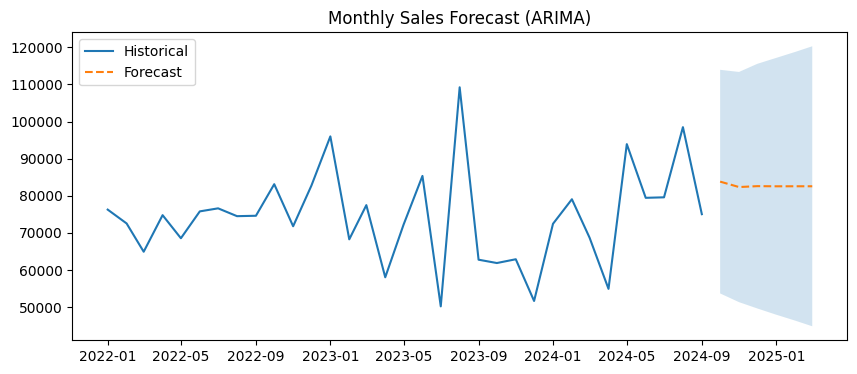

In [13]:
sales_series = monthly.set_index('Month_dt')['Sales']
model = ARIMA(sales_series, order=(1,1,1)).fit()
f = model.get_forecast(steps=6)
fidx = pd.date_range(start=sales_series.index[-1] + pd.offsets.MonthBegin(1), periods=6, freq='MS')
fc = pd.DataFrame({'Month': fidx, 'Forecast': f.predicted_mean, 'Lower': f.conf_int().iloc[:,0].values, 'Upper': f.conf_int().iloc[:,1].values})
plt.figure(figsize=(10,4))
plt.plot(sales_series.index, sales_series, label='Historical')
plt.plot(fc['Month'], fc['Forecast'], label='Forecast', linestyle='--')
plt.fill_between(fc['Month'], fc['Lower'], fc['Upper'], alpha=0.2)
plt.legend(); plt.title("Monthly Sales Forecast (ARIMA)")
plt.show()
# Manually save this plot from the notebook viewer as "sales_forecast.png" if needed.


In [14]:
import os
os.makedirs("data", exist_ok=True)
df.to_csv("data/superstore_clean.csv", index=False)
print("Saved cleaned csv -> data/superstore_clean.csv")


Saved cleaned csv -> data/superstore_clean.csv
